### Исходное задание 
1. нужно скачивать информацию о блоке и сохранять (чтобы каждый раз не тянуть данные, а если нужно то подгрузить, лучше в несколько потоков)
http://93.125.26.210:34657/block?height=300
2. далее распарсить итеративно все блоки и сохранить информацию о коммитах для каждого валидатора для каждого блока
3. нарисовать графики для валидаторов, график лайфтайма
4. расчитать вознаграждение для каждого исходя из линейно возрастающей награды за каждый блок
5. выдать таблицу - валидатор, баланс

In [1]:
import pandas as pd

In [2]:
from tqdm import tqdm_notebook

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import plotly.graph_objects as go

In [5]:
import numpy as np

In [6]:
# validators_df = pd.read_csv("euler_validators_2.csv", usecols=["block", "validators"])

In [7]:
# validators_df[["block", "validators"]].to_csv("euler_validators.csv")

In [8]:
validators_df = pd.read_csv("euler_validators.csv")

In [9]:
validators_df["validators"] = validators_df["validators"].apply(lambda x: eval(x))

In [10]:
# validators_df["validators"] = validators_df["validators"].apply(lambda x: set(x))

In [11]:
all_validators = set([v for v_list in validators_df["validators"].tolist() for v in v_list])

### Визуализация работы валидаторов

In [79]:
# Последний актуальный блок
MAX_BLOCK = validators_df["block"].max()
MAX_BLOCK

3665414

In [58]:
validators_df["rounded_block"] = validators_df["block"].round(-4)

In [59]:
validators_df["rounded_block"].nunique()

368

In [60]:
x = validators_df["rounded_block"].unique().tolist()

In [61]:
all_y = []
labels = []
validator_traces = {}
for validator in tqdm_notebook(all_validators):
    validators_df["validator_mask"] = validators_df["validators"].apply(lambda x: validator in x).astype(float)
    y = validators_df.groupby("rounded_block")["validator_mask"].sum().tolist()
    all_y.append(y)
    labels.append(validator)
    validator_traces[validator] = y

In [76]:
import matplotlib
cmap = matplotlib.cm.get_cmap('jet')

In [77]:
validator_colors = {
    validator: "rgba({})".format(", ".join([str(int(color * 255)) for color in cmap(np.sum(trace) / MAX_BLOCK)]))
    for validator, trace in validator_traces.items()
}

In [81]:
fig = go.Figure()

for validator, y in validator_traces.items():
    fig.add_trace(go.Scatter(
        x=x, y=y,
        mode='lines',
        name=validator[0:5] + "...",
        line=dict(width=0.5, color=validator_colors[validator]),
        stackgroup='one',
        groupnorm='percent'
    ))

fig.update_layout(
    showlegend=True,
    xaxis_type='linear',
    yaxis=dict(
        type='linear',
        range=[1, 100],
        ticksuffix='%'))

fig.show()

### Расчет вознаграждения для каждого валидатора

In [83]:
# Количество токенов, участвующее в раздаче
AMOUNT_OF_TOKENS = 10000000

In [84]:
# Коэффициенты прямой для вычисления вознаграждения
K = 1
B = 0

Вопрос: как влияют эти коэффициенты на вознаграждение валидаторов?

In [85]:
def linear(block):
    return K * block + B

In [86]:
validators_df["total_reward_part"] = validators_df["block"].apply(lambda x: linear(x)) 

In [87]:
validators_df["total_validators"] = validators_df["validators"].apply(lambda x: len(x))

In [88]:
validators_df["validator_reward_part"] = validators_df["total_reward_part"] / validators_df["total_validators"] / validators_df["total_reward_part"].sum()

In [90]:
rewards = {}

for validator in tqdm_notebook(all_validators):
    validator_reward = validators_df[validators_df["validators"].apply(lambda x: validator in x)]["validator_reward_part"].sum()
    rewards[validator] = validator_reward * AMOUNT_OF_TOKENS

In [91]:
balances_df = pd.Series(rewards).to_frame().reset_index().rename(columns={0: "balance", "index": "address"}).set_index("address").sort_values("balance", ascending=False)

In [92]:
balances_df.to_csv("balances.csv")

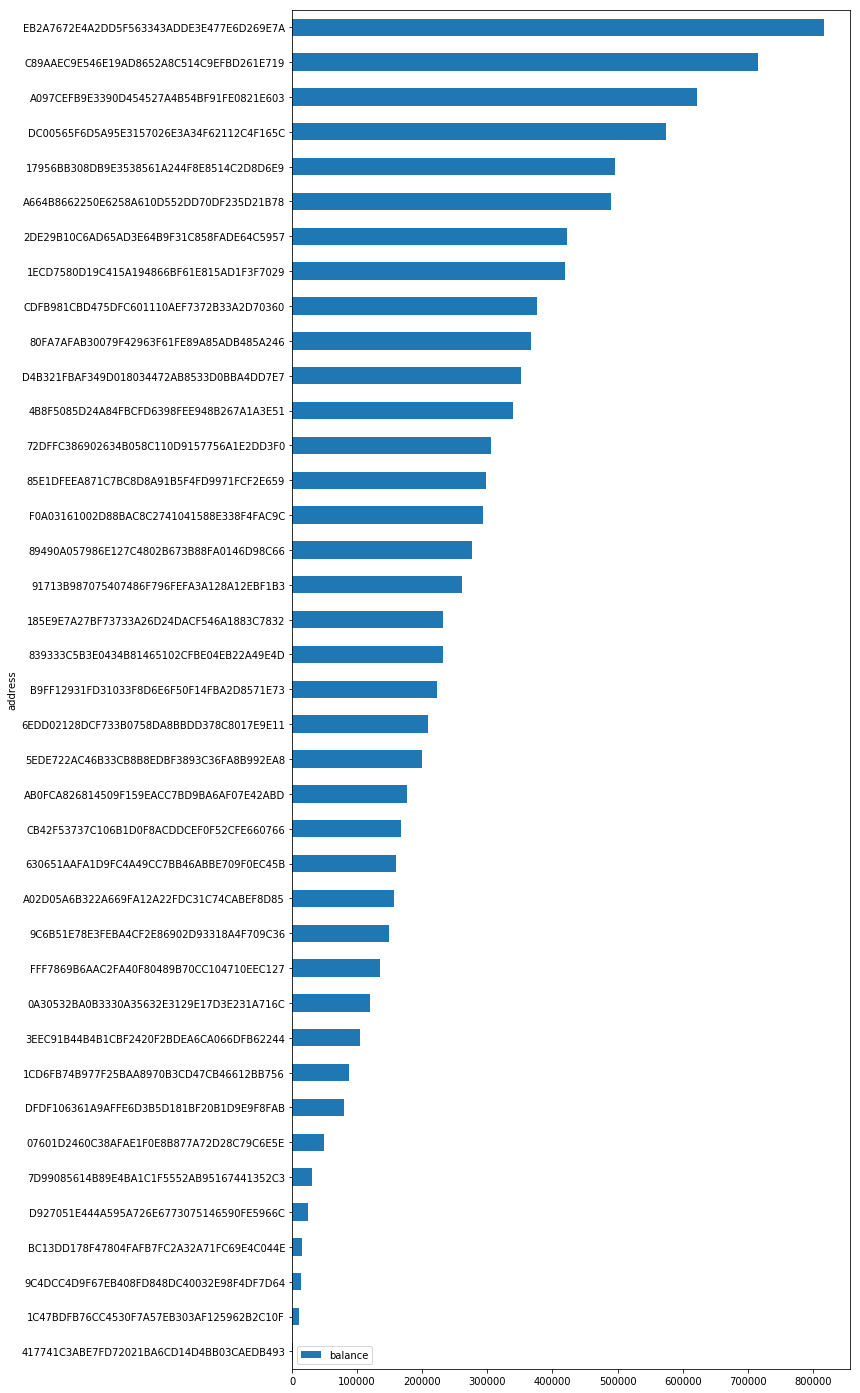

In [99]:
balances_df.sort_values("balance").plot(kind="barh", figsize=(10, 25))

In [100]:
balances_df

,balance
address,
EB2A7672E4A2DD5F563343ADDE3E477E6D269E7A,816403.338641
C89AAEC9E546E19AD8652A8C514C9EFBD261E719,715453.327464
A097CEFB9E3390D454527A4B54BF91FE0821E603,622534.997588
DC00565F6D5A95E3157026E3A34F62112C4F165C,574502.257609
17956BB308DB9E3538561A244F8E8514C2D8D6E9,495950.463052
A664B8662250E6258A610D552DD70DF235D21B78,490385.523329
2DE29B10C6AD65AD3E64B9F31C858FADE64C5957,422555.015589
1ECD7580D19C415A194866BF61E815AD1F3F7029,418731.936473
CDFB981CBD475DFC601110AEF7372B33A2D70360,376081.430124
